# **Importing the libraries**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-07-02 20:37:29.111668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751488649.337067      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751488649.396590      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading and Splitting the dataset**

In [2]:
data, info = tfds.load('oxford_iiit_pet', with_info=True)
train_ds = data['train']
test_ds = data['test']
IMG_SIZE = 128

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1751488833.597947      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751488833.598630      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.S30NPX_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.S30NPX_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


# **Preprocessing the Data**

In [3]:
def preprocess_sample(sample):
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = tf.image.resize(sample['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask > 1, tf.uint8)
    return image, mask

train = train_ds.map(preprocess_sample).cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test = test_ds.map(preprocess_sample).batch(32).prefetch(tf.data.AUTOTUNE)

# **Building a U-Net model with a ResNet50 encoder**

In [4]:
def unet_model(output_channels):
    base_model = tf.keras.applications.ResNet50(input_shape=[IMG_SIZE, IMG_SIZE, 3],
                                                include_top=False, weights='imagenet')

    layer_names = [
        'conv1_relu',
        'conv2_block3_out',
        'conv3_block4_out',
        'conv4_block6_out',
    ]
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]

    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)
    down_stack.trainable = False

    def upsample(filters, size):
        return tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', activation='relu')

    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    for up, skip in zip([512, 256, 128, 64], skips):
        x = upsample(up, 3)(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = upsample(64, 3)(x)
    outputs = tf.keras.layers.Conv2D(output_channels, 1, activation='softmax')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model = unet_model(output_channels=2)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

# **Training the model**

In [7]:
history = model.fit(train, validation_data=test, epochs=50)

Epoch 1/50


I0000 00:00:1751488877.630745     120 service.cc:148] XLA service 0x7db5f4004e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751488877.631600     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751488877.631617     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1751488878.397940     120 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1751488879.019960     120 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751488891.923115     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7246 - loss: 0.5673

W0000 00:00:1751488910.921122     117 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1751488920.164903     117 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1751488924.224566     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751488924.505690     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


115/115 ━━━━━━━━━━━━━━━━━━━━ 59s 294ms/step - accuracy: 0.7249 - loss: 0.5668 - val_accuracy: 0.7829 - val_loss: 0.4645
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.7823 - loss: 0.4645 - val_accuracy: 0.7776 - val_loss: 0.4724
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.7846 - loss: 0.4596 - val_accuracy: 0.7872 - val_loss: 0.4590
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - accuracy: 0.7914 - loss: 0.4511 - val_accuracy: 0.7905 - val_loss: 0.4543
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.7882 - loss: 0.4552 - val_accuracy: 0.7939 - val_loss: 0.4487
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.7949 - loss: 0.4454 - val_accuracy: 0.7951 - val_loss: 0.4443
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 231ms/step - accuracy: 0.7972 - loss: 0.4424 - val_accuracy: 0.8043 - val_loss: 0.4359
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - accuracy: 0.8028 - loss: 0.4336 - val

# **Visualizing the Model's Training History**

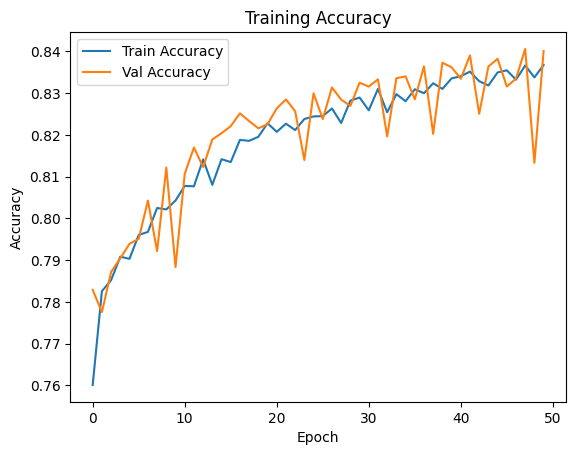

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

# **Evaluating the model using Confusion Matrix and Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

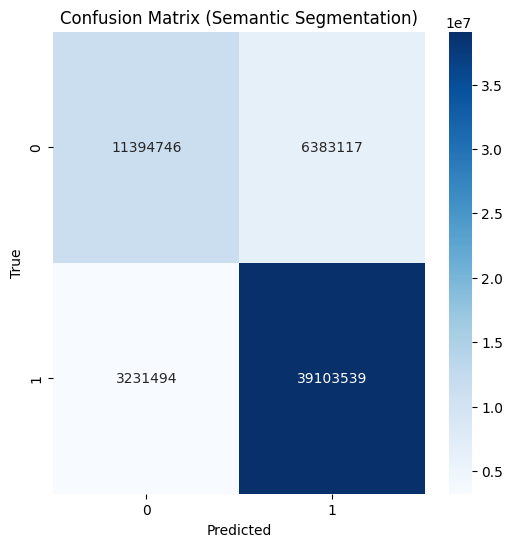

              precision    recall  f1-score   support

  Background       0.78      0.64      0.70  17777863
         Pet       0.86      0.92      0.89  42335033

    accuracy                           0.84  60112896
   macro avg       0.82      0.78      0.80  60112896
weighted avg       0.84      0.84      0.84  60112896



In [9]:
y_true = []
y_pred = []

for images, masks in test:
    preds = model.predict(images)
    masks_np = masks.numpy().flatten()
    preds_np = tf.argmax(preds, axis=-1).numpy().flatten()
    y_true.extend(masks_np)
    y_pred.extend(preds_np)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d")
plt.title("Confusion Matrix (Semantic Segmentation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Background", "Pet"]))

# **Visualizing Model Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


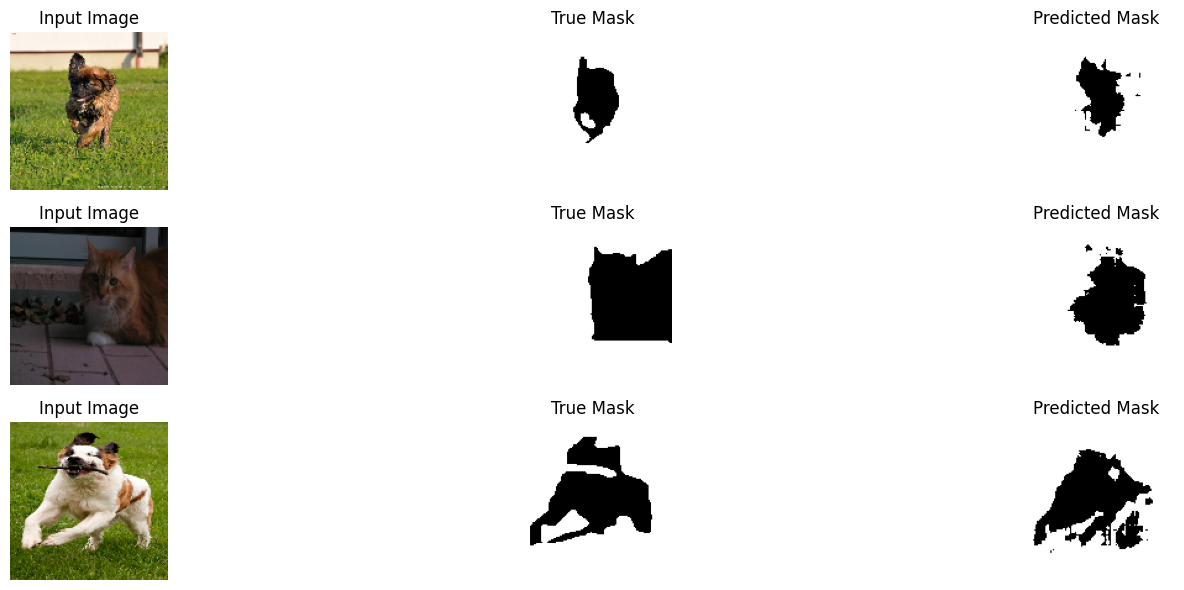

In [10]:
for images, masks in test.take(1):
    preds = model.predict(images)
    pred_masks = tf.argmax(preds, axis=-1)

    plt.figure(figsize=(18, 6))
    for i in range(3):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(tf.squeeze(masks[i]), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(tf.squeeze(pred_masks[i]), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()